# Stray light when using excitation FW

Investigate the effects of removing excitation filters from the cube changer and instead placing them in a filter wheel in the common laser path (after MUX, before projection optics). In particular, during acquisition there will be some time during which there is a mismatch between excitation filter at the wheel and dichroic filter in the cube. How much light is reflected onto the sample during this time?


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from interferenceFilter import InterferenceFilter
from camera import Camera
from objective import Objective
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'


In [3]:
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)

lasers = [l700, l633, l594, l532, l405]

ex405 = InterferenceFilter(name='405 ex', spectrum=(os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt')))
ex532 = InterferenceFilter(name='532 ex', spectrum=(os.path.join(filtersPath, 'FF01-532_3_spectrum.txt')))
ex594 = InterferenceFilter(name='594 ex', spectrum=(os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt')))
ex633 = InterferenceFilter(name='633 ex', spectrum=(os.path.join(filtersPath, 'FF01-640_14_spectrum.txt')))
ex700 = InterferenceFilter(name='700 ex', spectrum=(os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt')))
exfilters = [ex700, ex633, ex594, ex532, ex405]

di405 = InterferenceFilter(name='405 di', spectrum=(os.path.join(filtersPath, 'Di02-R405_Spectrum.txt')))
di532 = InterferenceFilter(name='532 di', spectrum=(os.path.join(filtersPath, 'Di02-R532_Spectrum.txt')))
di594 = InterferenceFilter(name='594 di', spectrum=(os.path.join(filtersPath, 'Di02-R594_Spectrum.txt')))
di633 = InterferenceFilter(name='633 di', spectrum=(os.path.join(filtersPath, 'Di02-R635_Spectrum.txt')))
di700 = InterferenceFilter(name='700 di', spectrum=(os.path.join(filtersPath, 'Chroma 725dcxxr.txt')))
difilters = [di700, di633, di594, di532, di405]


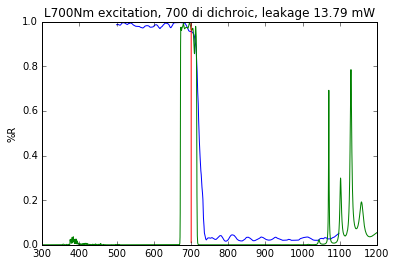

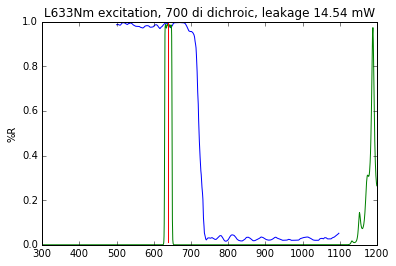

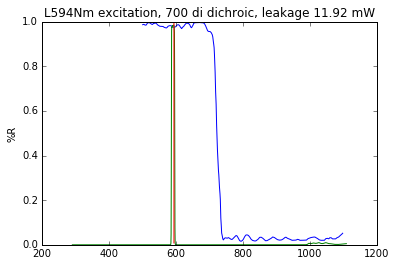

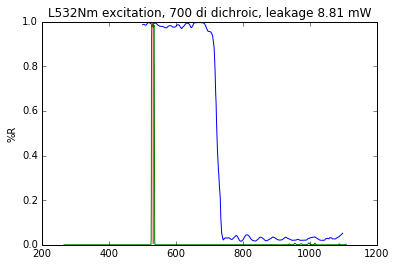

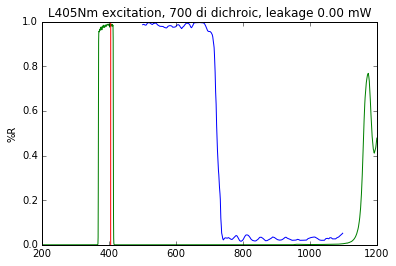

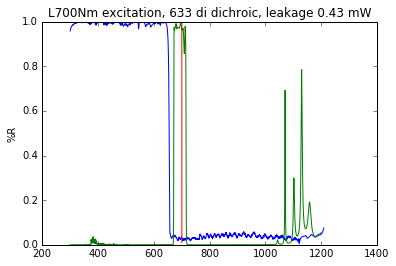

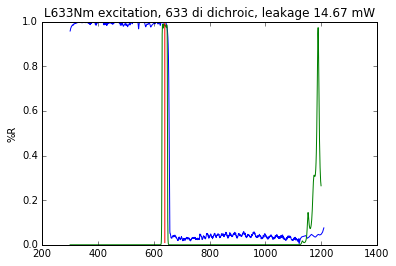

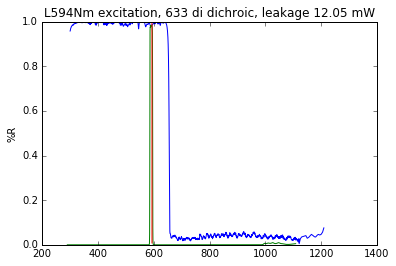

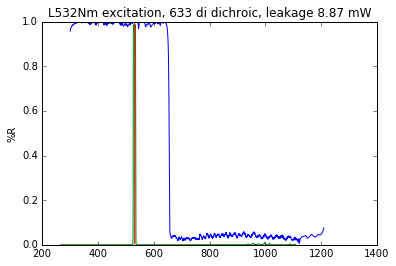

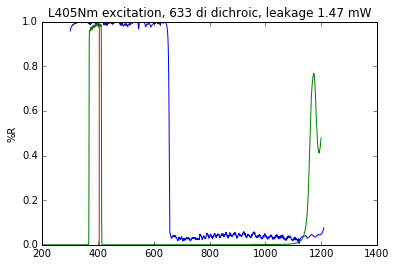

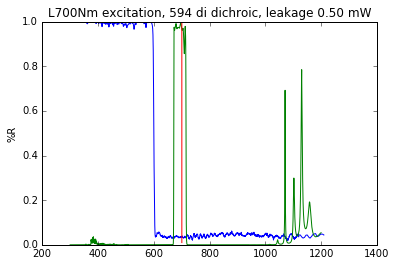

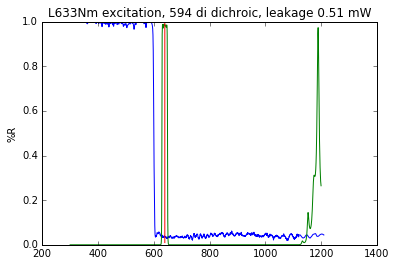

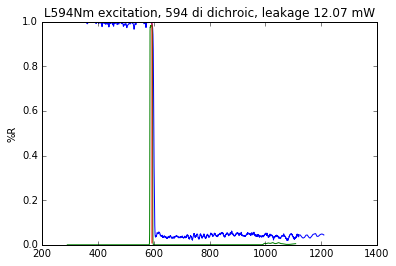

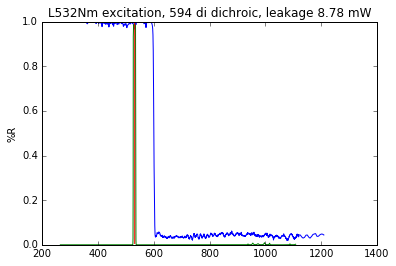

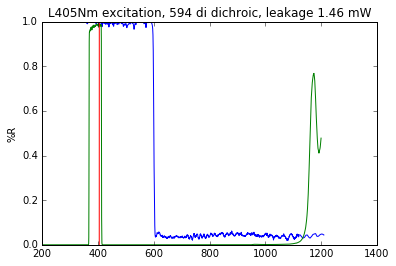

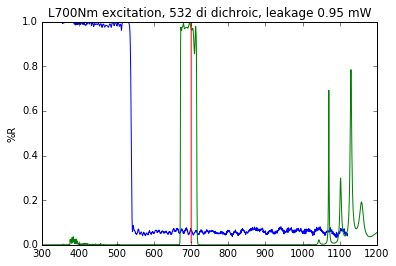

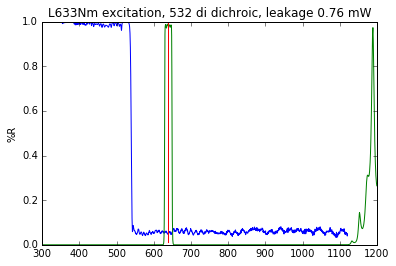

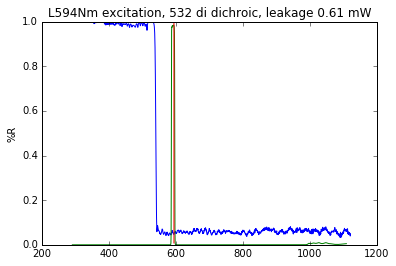

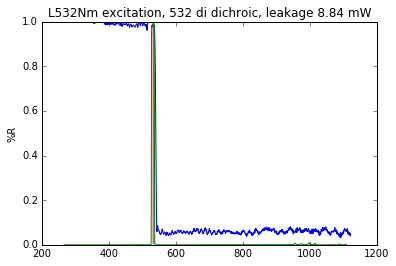

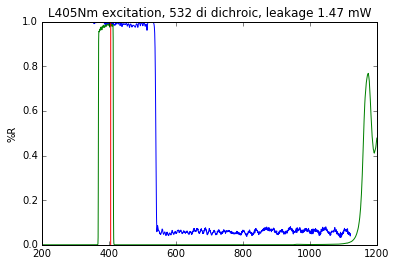

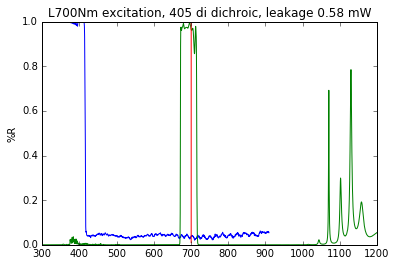

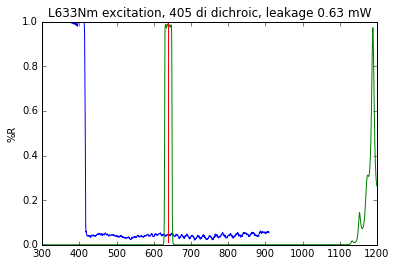

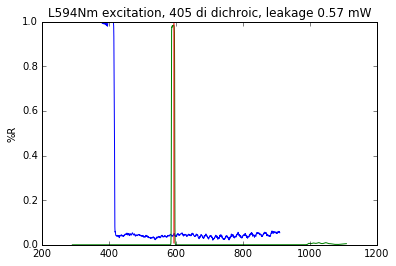

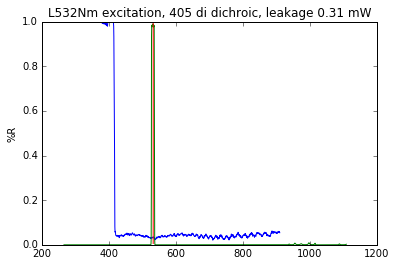

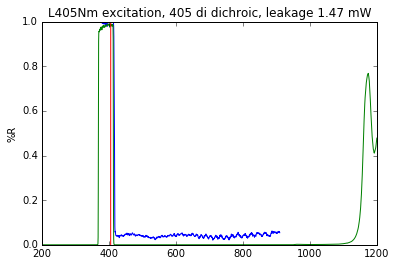

[[13.789714706640126, 14.535771753708818, 11.923346621197041, 8.8056024472434089, 0.0], [0.42690998821172943, 14.668646020880841, 12.049625296417149, 8.87356847297022, 1.4671778362445325], [0.50093431387678444, 0.51083834750257162, 12.070794153574807, 8.7761865297484736, 1.4611778577029988], [0.94847411609948096, 0.75948318410660709, 0.60751139704477464, 8.841212489308159, 1.4687147944977916], [0.57654823993707616, 0.625695886550511, 0.56647044230765353, 0.31149913510410288, 1.4680304064786731]]


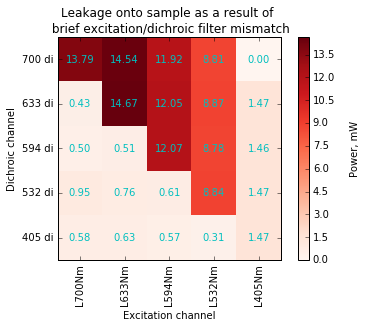

In [62]:
def powerAtSampleForExDiCombo(laser, exfilter, difilter):
    # calculate the power reaching the sample for a given combination of laser, excitation filter and dichroic
    
    dlambda = 0.5
    lsr = utils.interpolateSpectrum(laser.laserProfile, dlambda)
    ex = utils.interpolateSpectrum(exfilter.getSpectrum(), dlambda)
    di = utils.interpolateSpectrum(difilter.getSpectrum(), dlambda)
    di[:,1] = 1 - di[:,1]
    plt.plot(di[:,0], di[:,1], ex[:, 0], ex[:, 1], lsr[:,0], lsr[:,1])
    plt.ylim(0,1)
    plt.ylabel('%R')

    signal = utils.integrateSpectra([lsr, ex, di], dlambda)
    plt.title('{} excitation, {} dichroic, leakage {:0.2f} mW'.format(laser.channel, difilter.name, signal))
    plt.show()
    
    return exfilter.name, difilter.name, signal

outputMat = []
for difilter in difilters:
    outputL = []
    for exfilter, laser in zip(exfilters, lasers):
        outputL.append(powerAtSampleForExDiCombo(laser, exfilter, difilter)[2])
    outputMat.append(outputL)
    
print(outputMat)
%matplotlib inline
plt.imshow(outputMat, cmap = 'Reds', interpolation='none')
hax = plt.gca()
hcbar = plt.colorbar()
hcbar.ax.get_yaxis().labelpad = 15    
hax.set_title('Leakage onto sample as a result of \n brief excitation/dichroic filter mismatch')
hcbar.ax.set_ylabel('Power, mW', rotation=90)
hax.set_xlabel('Excitation channel')
hax.set_ylabel('Dichroic channel')
di_labels = [di.name for di in difilters]
lsr_labels = [l.channel for l in lasers]
di_labels.insert(0, '')
lsr_labels.insert(0, '')
hax.set_xticklabels(lsr_labels, rotation=90)
hax.set_yticklabels(di_labels)

# add data labels
for x in range(len(lasers)):
    for y in range(len(difilters)):
        plt.text(x,y,'{:0.2f}'.format(outputMat[y][x]), 
                 horizontalalignment='center', 
                 verticalalignment='center', 
                 color = 'c')

[ 345.   345.2  345.4 ...,  909.6  909.8  910. ]
